# AI Summit 2019 Workshop - RecSys ML and DNN

-- [ 전용준. YONG. Yong Xune Xon. 리비젼컨설팅. revisionconsulting. revision.co.kr. xyxonxyxon@empal.com ]
<br> Updated Version as of 20200130. <br>
- clustering
- collaborative filtering
- deep learning

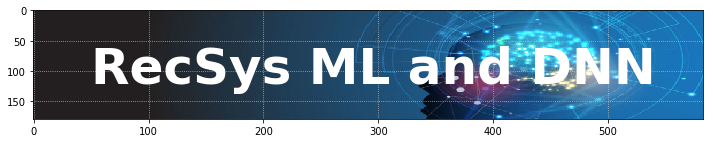

In [197]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('http://cfile209.uf.daum.net/image/99F55F335DDB5F4112D958') 
  
# Output Images 
plt.figure(figsize=(12,2))
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,120, 'RecSys ML and DNN', color='white', size=50, weight='bold')
plt.show()


In [198]:
# 기본 라이브러리 로딩 및 사용자 정의함수 정의

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')


# to set github url as data path
dataPath = 'https://github.com/stillxyxon/aisummitRecSys20/raw/master/'

# define universally useful UDFs

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def rjitt2(arr):
    stdev = .031*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

# custom one-hot encoder
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

## 1. Dataset Loading
- A publicly availble dataset of B2B online retailer
- Data source : https://archive.ics.uci.edu/ml/datasets/online+retail 
- Most of the customers are wholesalers in Europe

In [199]:
# load dataset

# tr01a = tr01.head(270955)
# tr01a.to_csv(dataPath + 'onlneRetail_A.csv', index=False)

print(dataPath + 'onlneRetail_A.csv')

tr01a = pd.read_csv(dataPath + 'onlneRetail_A.csv')

# tr01b = tr01.tail(270954)
# tr01b.to_csv(dataPath + 'onlneRetail_B.csv', index=False)
tr01b = pd.read_csv(dataPath + 'onlneRetail_B.csv')

# to bypass github upload size limitation, read pre-split datasets and merge
tr01 = pd.concat([tr01a, tr01b], axis=0)
print(tr01.shape)

# consider valid transactions only
tr01 = tr01[(tr01.Quantity>0) & tr01.UnitPrice>0]

SCdesc_mast = tr01[['StockCode','Description']].drop_duplicates()

print(len(tr01.CustomerID.unique()))
tr01.head()

https://github.com/stillxyxon/aisummitRecSys20/raw/master/onlneRetail_A.csv
(541909, 8)
4339


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [200]:
# get list of unique customers

ucusts = list(tr01.CustomerID.unique().astype(int))

import random 

random.sample(ucusts, 100)[:5]

[17879, 13561, 17238, 17787, 16531]

### 2. EDA to design and scope the recsys
- Get frequency for each StockCode (=Item)

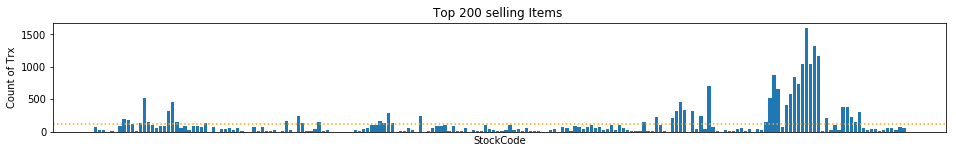

out of  3922  total unique stockcodes


,StockCode,InvoiceNo
3407,85123A,2265
3387,85099B,2112
1310,22423,2017
2670,47566,1706
175,20725,1595


In [201]:
df101 = tr01[['InvoiceNo', 'StockCode']].groupby('StockCode').count().reset_index()

plt.figure(figsize=(16,2))
plt.bar(df101.head(200).StockCode, df101.head(200).InvoiceNo)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.axhline(df101.head(200).InvoiceNo.mean(), color='orange', linestyle=':')
plt.title('Top 200 selling Items ')
plt.ylabel('Count of Trx')
plt.xlabel('StockCode')
plt.show()

nitm = 50
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)
# print(df101.InvoiceNo.sum())
print('out of ', len(np.unique(tr01.StockCode)), ' total unique stockcodes')
df101.head()

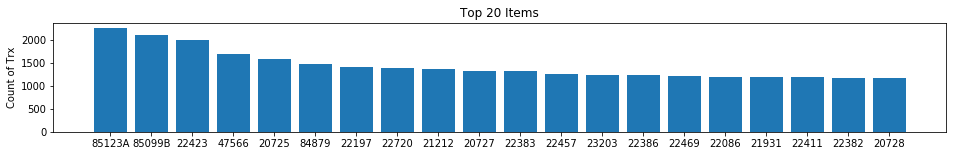

In [202]:
plt.figure(figsize=(16,2))
plt.bar(df101.StockCode[:20], df101.InvoiceNo[:20])
plt.title('Top 20 Items')
plt.ylabel('Count of Trx')
plt.show()

- <font color='blue'>Notice that POST is not an item appropriate to be recommended</font>. That's why we need EDA before getting into the main job.

In [203]:
trxdtlcnt = tr01.shape[0]
trxdtlcnt_top20 = tr01[tr01.StockCode.isin(df101.StockCode)].shape[0]
print(trxdtlcnt_top20, trxdtlcnt, '\nTop ', nitm,' items account for ',
      round(trxdtlcnt_top20/trxdtlcnt*100,2), '% of total count of transaction detail')

60028 530106 
Top  50  items account for  11.32 % of total count of transaction detail


- [참고] 전체 건수에서 Top 10 items 차지하는 건수 비중이 크지 않지만 단순화하기 위해 여기서는 Top 20~50으로 한정해서
- 실전에서라면 적어도 20~50% coverage 수준의 items을 적용해야 할 것. item 선정하기 위한 추가 작업도 필요

In [204]:
ustockcodes = list(tr01.StockCode.unique())
print(len(ustockcodes))

3922


- 정상매출로 보이는 3922개 stockcode 중 Top 500개를 선정하는 경우 51.04% 정도의 trx cnt를 커버할 수 있음

In [205]:
select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
print(tr02.shape)
tr02.head()
print('Num of Cust ', len(tr02.CustomerID.unique()))

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728', '22961', '23298', '22960', 'POST', '22666', '23209', '22384', '82482', '22993', '22699', '22727', '23206', '22178', '20724', '20726', '22697', '23084', '21080', '22726', '23199', '22077', '22139', '21034', '22138', '85099C', '22470', '21790', '23301', '82494L', '84946']
50
(60028, 8)
Num of Cust  3763


# 3. Clustering 
- Clustering Users to make recommendations

- K-Prototype Algorithm for Clustering Mixed attributes - combining k-means and k-modes
- k-modes clustering for categorical data. The mode of a set of data values is the value that appears most often.

In [206]:
# Use only Top 20 items for simplicity

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
tr02.head()

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728']
20


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 8:34,1.69,13047.0,United Kingdom
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 9:00,2.55,13748.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 9:02,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 9:32,2.55,17850.0,United Kingdom


In [207]:
# 고객별 stockcode별 invoice count 집계 

tr03 = tr02[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

# pivoting to make long format table to wide format table 

tr04c = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04c.fillna(0, inplace=True)
print(tr04c.shape)
tr04c.head()

(11191, 3)
(3154, 21)


StockCode,CustomerID,20725,20727,20728,21212,21931,22086,22197,22382,22383,...,22411,22423,22457,22469,22720,23203,47566,84879,85099B,85123A
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
3,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
# to create a categorical feature - Most frequent country

idx = tr02[['InvoiceNo','CustomerID','Country']].groupby(['CustomerID','Country'])['InvoiceNo'].transform(max) == tr02['InvoiceNo']
tr04cc = tr02[idx].reset_index()[['CustomerID', 'Country']]
tr04cc.head()


,CustomerID,Country
0,18074.0,United Kingdom
1,18074.0,United Kingdom
2,16250.0,United Kingdom
3,17908.0,United Kingdom
4,17908.0,United Kingdom


In [209]:
# 주로 거래건이 발생되는 country의 분포 (고객별)
tr04cc1 = tr04cc.Country.value_counts().reset_index().head(10)
tr04cc1

,index,Country
0,United Kingdom,5539
1,France,117
2,Germany,94
3,Portugal,43
4,Spain,38
5,Belgium,37
6,Switzerland,29
7,Italy,22
8,Channel Islands,22
9,Cyprus,18


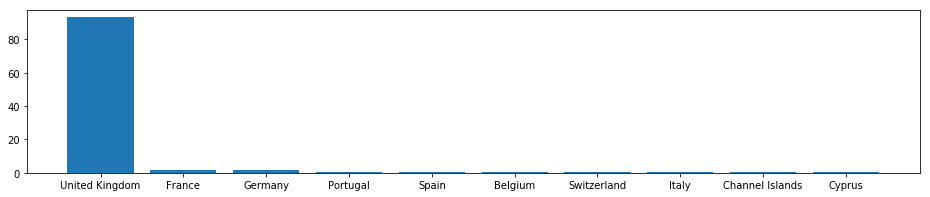

In [212]:
plt.figure(figsize=(16,3))
plt.bar(tr04cc1['index'] , tr04cc1['Country']/tr04cc1['Country'].sum()*100);

# More than 80% are from UK. But there are some from other countries.

In [213]:
# merge categorical feature 'Country'

tr04c = tr04c.merge(tr04cc, how='left', on='CustomerID')
# Encoding categorial feature can improve processing efficiency

# fill NAs
tr04c['Country'].fillna('NA', inplace=True)
tr04c.head()

,CustomerID,20725,20727,20728,21212,21931,22086,22197,22382,22383,...,22423,22457,22469,22720,23203,47566,84879,85099B,85123A,Country
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
1,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy
2,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy
3,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Norway
4,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spain


In [ ]:
# pip install kmodes

In [214]:
#  https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914

from kmodes.kprototypes import KPrototypes
# kprototypes algorithm uses k-modes for categorical vars and k-means for numeric vars

dfkprt = tr04c.ix[:,:22]

kproto = KPrototypes(n_clusters=10, verbose=0)

X = np.array(dfkprt)
clusters = kproto.fit_predict(X, categorical=[21])

# Print cluster centroids of the trained model.
# print(kproto.cluster_centroids_)
# Print training statistics
# print(kproto.cost_)

print('iterations :', kproto.n_iter_)

dfkprt['clst'] = clusters
dfkprt.head()

iterations : 22


,CustomerID,20725,20727,20728,21212,21931,22086,22197,22382,22383,...,22457,22469,22720,23203,47566,84879,85099B,85123A,Country,clst
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland,7
1,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy,7
2,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Italy,7
3,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Norway,7
4,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spain,7


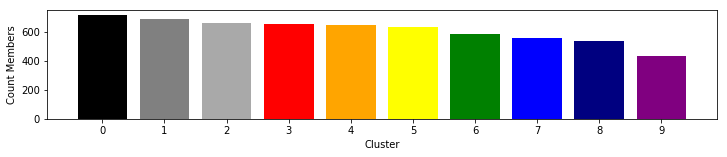

In [216]:
# check distribution of frequency (num of members) in each cluster

colist = ['black', 'grey', 'darkgrey', 'red', 'orange', 
          'yellow', 'green', 'blue', 'navy', 'purple']            

plt.figure(figsize=(12,2))
plt.bar(np.array(range(10)).astype(str), dfkprt['clst'].value_counts(),
       color = colist)
plt.xlabel('Cluster')
plt.ylabel('Count Members')
plt.show()

In [217]:
# 값이 많은 Top 5
print(dfkprt.iloc[:,1:20].sum(axis=0).sort_values().tail())

tr01[tr01.StockCode.isin(['85099B','20725'])].head()

22423     3648.0
20727     3818.0
22383     4104.0
20725     4514.0
85099B    4959.0
dtype: float64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
93,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 9:37,1.65,14688.0,United Kingdom
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 9:57,1.65,16029.0,United Kingdom
234,536390,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 10:19,1.65,17511.0,United Kingdom
368,536401,20725,LUNCH BAG RED RETROSPOT,1,2010-12-01 11:21,1.65,15862.0,United Kingdom
533,536409,85099B,JUMBO BAG RED RETROSPOT,2,2010-12-01 11:45,1.95,17908.0,United Kingdom


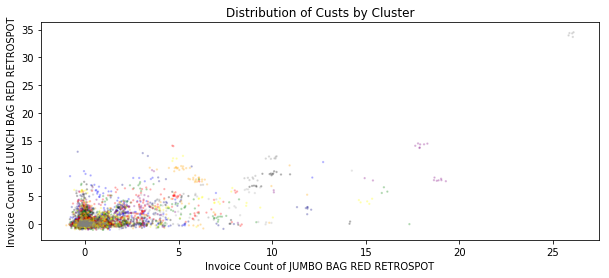

In [218]:
colors1 = [colist[x] for x in clusters]

plt.figure(figsize=(10,4))
plt.scatter(rjitt(dfkprt['85099B']), rjitt(dfkprt['20725']),
            color=colors1, alpha=0.2, s=2)
plt.title('Distribution of Custs by Cluster')
plt.xlabel('Invoice Count of JUMBO BAG RED RETROSPOT')
plt.ylabel('Invoice Count of LUNCH BAG RED RETROSPOT')    
plt.show()

- 2 top selling items 을 기준으로 scatter plot에서 cluster가 혼재하는 양상을 보인다는 것은?
- 2 top selling items 만으로는 극히 일부분 밖에는 설명할 수 없다는 의미
- Cluster 특징 profiling을 위해 DT, Catboost (Var Importance) 활용 가능

In [219]:
# Profile Clusters : Most popular items in each cluster

for x in range(3):
    mems = dfkprt[dfkprt.clst ==x]['CustomerID']
    tr02tmp = tr02[tr02.CustomerID.isin(mems)][['InvoiceNo','Description']].groupby(['Description']).count().reset_index()
    print('\nSegment', x , '.............\n')
    print(tr02tmp.sort_values('InvoiceNo', ascending=False).head(7))


Segment 0 .............

                           Description  InvoiceNo
22  WHITE HANGING HEART T-LIGHT HOLDER        204
19            REGENCY CAKESTAND 3 TIER        195
0        ASSORTED COLOUR BIRD ORNAMENT        136
4              JUMBO BAG RED RETROSPOT        125
17                       PARTY BUNTING        120
10             LUNCH BAG RED RETROSPOT         94
16     PAPER CHAIN KIT 50'S CHRISTMAS          94

Segment 1 .............

                           Description  InvoiceNo
23  WHITE HANGING HEART T-LIGHT HOLDER        213
9              LUNCH BAG  BLACK SKULL.        126
5              JUMBO BAG RED RETROSPOT        122
14              LUNCH BAG SUKI DESIGN         110
11             LUNCH BAG RED RETROSPOT        109
20            REGENCY CAKESTAND 3 TIER        103
18                       PARTY BUNTING        101

Segment 2 .............

                           Description  InvoiceNo
24  WHITE HANGING HEART T-LIGHT HOLDER        263
5              JUMBO B

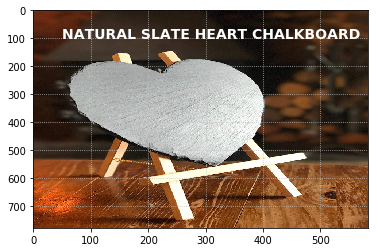

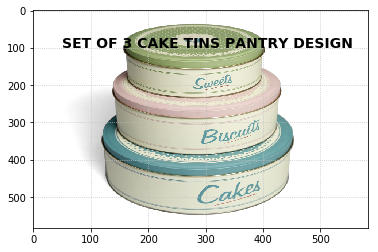

In [220]:
# What are the items actually?

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# NATURAL SLATE HEART CHALKBOARD
img = mpimg.imread('http://cfile215.uf.daum.net/image/99084B505DDCB8B31138D8') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,100, 'NATURAL SLATE HEART CHALKBOARD', color='white', size=14, weight='bold')
plt.show()

# SET OF 3 CAKE TINS PANTRY DESIGN    
img = mpimg.imread('http://cfile230.uf.daum.net/image/99AA6E505DDCB8BA086839') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.text(50,100, 'SET OF 3 CAKE TINS PANTRY DESIGN', size=14, weight='bold')
plt.show()

- cluster별로 top selling items 구성이 다르다는 것은 cluster를 기준으로 상품 추천시 고객별로 서로 다른 item이 추천될 수 있다는 의미
- customer를 cluster 할 것인가 item을 cluster 할 것인가?

# 4. Collaborative Filtering
- Impementing Item based Fitering

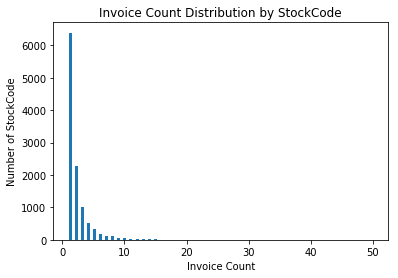

,StockCode,CustomerID,InvoiceCnt
0,20725,12354.0,1
1,20725,12361.0,1
2,20725,12362.0,2
3,20725,12371.0,1
4,20725,12378.0,1


In [221]:
# create item-user matrix 
# tr02.head()

itmusr_mtrx =  tr02[['InvoiceNo', 'StockCode', 'CustomerID']].groupby(['StockCode','CustomerID']).count().reset_index()
itmusr_mtrx.columns = ['StockCode', 'CustomerID', 'InvoiceCnt']

plt.hist(itmusr_mtrx.InvoiceCnt, bins=100) 
plt.title('Invoice Count Distribution by StockCode')
plt.xlabel('Invoice Count')
plt.ylabel('Number of StockCode')
plt.show()

itmusr_mtrx.head()

- 20개 item간의 관계만을 사용해서 CF (for simlicity)
- 실제 구현시에는 item 수 대폭 increase 필요
- Invoice Count 대신 Invoice 여부를 사용할 수도, 다른 metric을 설계할 수도 있음

3154  customers
20  items
iteration .....  1
iteration .....  2
iteration .....  3
iteration .....  4
iteration .....  5
iteration .....  6
iteration .....  7
iteration .....  8
iteration .....  9
iteration .....  10
iteration .....  11
iteration .....  12
iteration .....  13
iteration .....  14
iteration .....  15
iteration .....  16
iteration .....  17
iteration .....  18
iteration .....  19
iteration .....  20


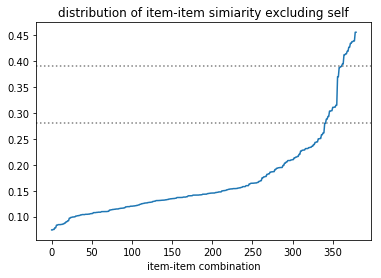

In [222]:
# create item-item matrix

custs = itmusr_mtrx.CustomerID.unique()
print(len(custs), ' customers')

scs = itmusr_mtrx.StockCode.unique()
nscs = len(scs)
print(nscs, ' items')
# create an empty matrix
w, h = 3, (nscs*nscs)
itmitm_mtrx = np.array([[None for x in range(w)] for y in range(h)])

seqi= 0
for i in scs:
    seqj = 0
    for j in scs:
        # print(i, j, type(i))
        tmpcustsi = itmusr_mtrx[itmusr_mtrx.StockCode ==i]['CustomerID'].unique()
        tmpcustsj = itmusr_mtrx[itmusr_mtrx.StockCode ==j]['CustomerID'].unique()
        # print(len(tmpcustsi), len(tmpcustsj))

        # print([seqi, seqj, len(set(tmpcustsi) & set(tmpcustsi)) , list(set().union(tmpcustsi, tmpcustsj))])
        
        # 비교대상이 되는 두 고객집단 (item i를 구매한 고객리스트와 j를 구매한 고객리스트) 간의 
        # 교집합 고객수를 합집합 고객수로 나눈 값으로 simiarity 측정
        itmitm_mtrx[(seqi*nscs) + seqj] = [i, j, len(set(tmpcustsi) & set(tmpcustsj)) / len(set().union(tmpcustsi, tmpcustsj))]
        if seqj<nscs:
            seqj = seqj + 1
            
    if seqi<nscs:        
        seqi = seqi + 1    
    print('iteration ..... ', seqi) 
        

itmitm_mtrx = pd.DataFrame(itmitm_mtrx)
itmitm_mtrx.columns =['StockCode','SCj','simScr']

plt.plot(np.sort(itmitm_mtrx[itmitm_mtrx.simScr<1].simScr))
plt.title('distribution of item-item simiarity excluding self')

# 추천시 사용할 cutoff 를 확인하기 위해
plt.axhline(np.percentile(itmitm_mtrx[itmitm_mtrx.simScr<1].simScr,95), linestyle=':', color='grey')
plt.axhline(np.percentile(itmitm_mtrx[itmitm_mtrx.simScr<1].simScr,90), linestyle=':', color='grey')
plt.xlabel('item-item combination')
plt.show()

In [47]:
# 합집합은 무시하고 교집합의 크기를 추가적인 가중치 factor로 사용하는 등 다양한 아이디어 활용 가능

In [223]:
print(itmitm_mtrx.shape)
# 20X20 matrix 이므로 400

itmitm_mtrx.head()

# itmitm_mtrx[itmitm_mtrx.StockCode.isin(['20725','20727'])]

(400, 3)


,StockCode,SCj,simScr
0,20725,20725,1
1,20725,20727,0.434783
2,20725,20728,0.438122
3,20725,21212,0.205579
4,20725,21931,0.233951


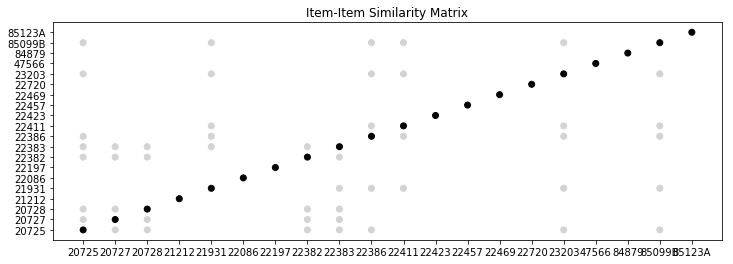

In [224]:
plt.figure(figsize=(12,4)) 
monocolpal = ['black', 'dimgray', 'darkgray', 'lightgrey', 'white']
simScr5 = 4-np.array(itmitm_mtrx.simScr * 4).astype(int)

colors1 = [monocolpal[x] for x in simScr5]
plt.scatter(itmitm_mtrx.StockCode, itmitm_mtrx.SCj, color=colors1)
plt.title('Item-Item Similarity Matrix')
plt.show()

- [ 참고 ] 교집합과 합집합간 비율로 계산하기에 매트릭스는 대칭 구조
- Pattern 특성 : Frequency가 높은 item은 다른 item들과의 similarity가 전반적으로 높음 (--> 추천 결과의 분산을 위해 의도적 조정 여지 존재)

### recommendation (inference) using item-based filtering

In [266]:
# create a cleansed item name master table

# 동일한 코드에 여러 description으로 표시된 경우
# 가장 빈도가 높은 description으로 통일

# SCdesc_mast = tr01[['StockCode','Description']].drop_duplicates()

multnmScList = SCdesc_mast.StockCode.value_counts()
multnmScList = multnmScList[multnmScList>1]
print('list of stockcode with multiple names \n', multnmScList[:10])
SCdesc_mast[SCdesc_mast.StockCode.isin(multnmScList[:5].index)].sort_values('StockCode')


list of stockcode with multiple names 
 23196     4
23236     4
23413     3
23209     3
23244     3
23240     3
23370     3
23203     3
23535     3
17107D    3
Name: StockCode, dtype: int64


,StockCode,Description
246802,23196,LEAVES MAGNETIC SHOPPING LIST
252851,23196,VINTAGE LEAF MAGNETIC NOTEPAD
238991,23196,RETO LEAVES MAGNETIC SHOPPING LIST
237422,23196,RETRO LEAVES MAGNETIC NOTEPAD
21722,23209,LUNCH BAG VINTAGE DOILY
20024,23209,LUNCH BAG VINTAGE DOILEY
179020,23209,LUNCH BAG DOILEY PATTERN
220496,23236,DOILEY BISCUIT TIN
19815,23236,STORAGE TIN VINTAGE DOILEY
218408,23236,DOILEY STORAGE TIN


In [267]:
dfscList = tr01[['StockCode','Description', 'InvoiceNo']].groupby(['StockCode','Description']).count().reset_index().sort_values(['StockCode','InvoiceNo'], ascending=False)

# list of multiple name items
dfscmulList = dfscList[dfscList.StockCode.isin(multnmScList.index)]
dfscmulList.head()

,StockCode,Description,InvoiceNo
3788,90014C,SILVER AND BLACK ORBIT NECKLACE,2
3789,90014C,SILVER/BLACK ORBIT NECKLACE,2
3786,90014B,GOLD M PEARL ORBIT NECKLACE,13
3787,90014B,GOLD M.O.P. ORBIT NECKLACE,2
3785,90014A,SILVER/MOP ORBIT NECKLACE,15


In [268]:
dfmxcntSCdesc = pd.DataFrame(dfscmulList.groupby(['StockCode'], sort=False).max()).reset_index()
dfmxcntSCdesc.head()

,StockCode,Description,InvoiceNo
0,90014C,SILVER/BLACK ORBIT NECKLACE,2
1,90014B,GOLD M.O.P. ORBIT NECKLACE,13
2,90014A,SILVER/MOP ORBIT NECKLACE,15
3,85185B,PINK HORSE SOCK PUPPET KIT,62
4,85184C,SET 4 VALENTINE DECOUPAGE HEART BOX,132


In [270]:
SCdesc_masta = SCdesc_mast[['StockCode']].drop_duplicates()
SCdesc_masta = SCdesc_masta.merge(dfmxcntSCdesc[['StockCode', 'Description']], on='StockCode', how='left')
SCdesc_masta[~SCdesc_masta.Description.isna()].sort_values('StockCode').head(500).tail(20)

,StockCode,Description
2034,84228,HEN HOUSE WITH CHICK STANDING
2274,84247E,PACK/12 XMAS FUN CARD
1279,84828,JUNGLE POPSICLES ICE LOLLY MOULDS
343,84906,PINK BUTTERFLY CUSHION COVER
963,84946,ANTIQUE SILVER TEA GLASS ETCHED
1127,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET
63,84997B,RED 3 PIECE RETROSPOT CUTLERY SET
64,84997C,CHILDRENS CUTLERY POLKADOT BLUE
597,84997D,PINK 3 PIECE POLKADOT CUTLERY SET
2950,84997a,GREEN 3 PIECE POLKADOT CUTLERY SET


In [271]:
# signle description case와 muliple description case 통합해 하나의 리스트 생성

dfscSnglList= SCdesc_mast[~SCdesc_mast.StockCode.isin(dfmxcntSCdesc.StockCode)]
print(dfscSnglList.sort_values('StockCode').head())
SCdesc_masta = SCdesc_masta.merge(dfscSnglList, on='StockCode', how='left')
print(SCdesc_masta.head())
SCdesc_masta['Description'] = SCdesc_masta.Description_x
SCdesc_masta['Description'] = np.where(SCdesc_masta.Description.isna(),SCdesc_masta.Description_y, SCdesc_masta.Description)
SCdesc_mast = SCdesc_masta[['StockCode','Description']]
SCdesc_masta.head()

       StockCode                  Description
31         10002  INFLATABLE POLITICAL GLOBE 
103332     10080     GROOVY CACTUS INFLATABLE
5452       10120                 DOGGY RUBBER
5451      10123C        HEARTS WRAPPING TAPE 
12492     10124A  SPOTS ON RED BOOKCOVER TAPE
  StockCode                       Description_x  \
0    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
1     71053        WHITE MOROCCAN METAL LANTERN   
2    84406B                                 NaN   
3    84029G                                 NaN   
4    84029E                                 NaN   

                         Description_y  
0                                  NaN  
1                                  NaN  
2       CREAM CUPID HEARTS COAT HANGER  
3  KNITTED UNION FLAG HOT WATER BOTTLE  
4       RED WOOLLY HOTTIE WHITE HEART.  


,StockCode,Description_x,Description_y,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE MOROCCAN METAL LANTERN,NaN,WHITE MOROCCAN METAL LANTERN
2,84406B,NaN,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER
3,84029G,NaN,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,NaN,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.


Customer  0  : 
-------------
 Bought : 
 ['NATURAL SLATE HEART CHALKBOARD '] 

 Recommends : 

  StockCode    simScr                         Description
0    85123A  1.000000  WHITE HANGING HEART T-LIGHT HOLDER
1     22469  0.994167               HEART OF WICKER SMALL
2     84879  0.735828       ASSORTED COLOUR BIRD ORNAMENT


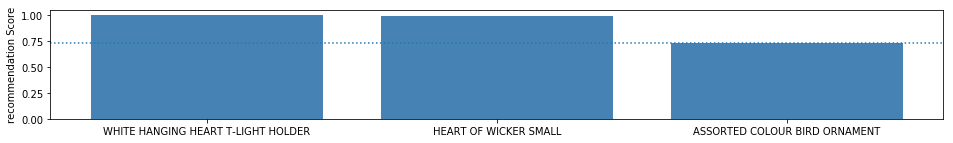

Customer  1  : 
-------------
 Bought : 
 ['JUMBO BAG RED RETROSPOT'] 

 Recommends : 

  StockCode    simScr                        Description
0     22386  1.000000            JUMBO BAG PINK POLKADOT
1     23203  0.937821           JUMBO BAG VINTAGE DOILY 
2     21931  0.771608             JUMBO STORAGE BAG SUKI
3     20725  0.769907               LUNCH BAG RED SPOTTY
4     22411  0.730272  JUMBO SHOPPER VINTAGE RED PAISLEY


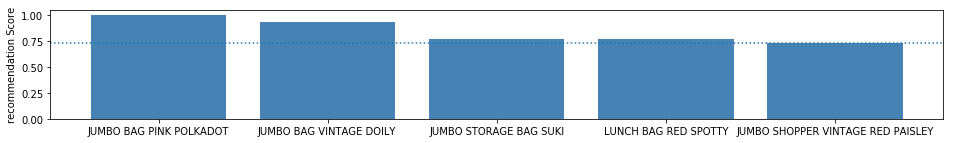

Customer  2  : 
-------------
 Bought : 
 ['REGENCY CAKESTAND 3 TIER' 'PARTY BUNTING'] 

 Recommends : 

  StockCode    simScr                         Description
0    85123A  1.000000  WHITE HANGING HEART T-LIGHT HOLDER
1     22720  0.999460   SET OF 3 CAKE TINS PANTRY DESIGN 
2     84879  0.991715       ASSORTED COLOUR BIRD ORNAMENT
3     21212  0.873696     PACK OF 72 RETROSPOT CAKE CASES
4     22423  0.565625            REGENCY CAKESTAND 3 TIER


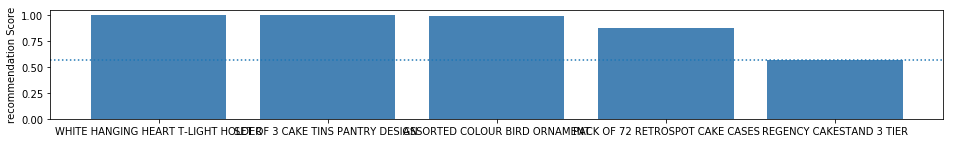

Customer  3  : 
-------------
 Bought : 
 ['WHITE HANGING HEART T-LIGHT HOLDER'] 

 Recommends : 

  StockCode    simScr                      Description
0     22469  1.000000            HEART OF WICKER SMALL
1     22457  0.916216  NATURAL SLATE HEART CHALKBOARD 
2     47566  0.851723                    PARTY BUNTING
3     84879  0.798926    ASSORTED COLOUR BIRD ORNAMENT
4     22423  0.773129         REGENCY CAKESTAND 3 TIER


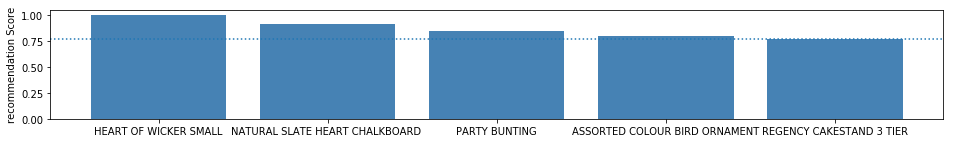

In [272]:
# to pick sample customers

import random
from random import sample 

smp_custs = np.array(random.sample(list(custs), 10)).astype(int)


# select items to recommend for each sample customer
for i in range(4):
    tmptrx = tr02[tr02.CustomerID == smp_custs[i]][['StockCode', 'CustomerID']].drop_duplicates()
    # Note: (itmitm_mtrx.simScr<1) prevents to recommend items already bought
    tmpsimmat01 = itmitm_mtrx[(itmitm_mtrx.simScr>0.15) & (itmitm_mtrx.simScr<1)][itmitm_mtrx.StockCode.isin(tmptrx.StockCode.unique())].drop_duplicates()
    tmpsimmat02 = tmpsimmat01[['SCj','simScr']].groupby('SCj').sum().reset_index()
    
    # rescale -- thus simScr indicates relative score
    tmpsimmat02['simScr'] = tmpsimmat02.simScr / tmpsimmat02.simScr.max()
    # print(tmpsimmat02.sort_values('simScr', ascending=False).head(5))
    dfrecomm = tmpsimmat02.sort_values('simScr', ascending=False).head(5)
    dfrecomm.columns = ['StockCode','simScr']
    dfrecomm = dfrecomm.merge(SCdesc_mast, how='left', on='StockCode')
    print('Customer ',i, ' : \n-------------\n', 
          'Bought : \n', np.array(SCdesc_mast[SCdesc_mast.StockCode.isin(tmptrx.StockCode.unique())].Description), '\n\n', 
          'Recommends : \n' )
    
    print(dfrecomm)
    plt.figure(figsize=(16,2)) 
    plt.bar(dfrecomm.Description, dfrecomm.simScr, color='steelblue')
    plt.axhline(dfrecomm.simScr.min(), linestyle=':')
    plt.ylabel('recommendation Score')
    plt.show()
    

# 5. DNN-based RecSys

In [273]:
# Use only Top 20 items

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]

['85123A', '85099B', '22423', '47566', '20725', '84879', '22197', '22720', '21212', '20727', '22383', '22457', '23203', '22386', '22469', '22086', '21931', '22411', '22382', '20728']
20


## 5.1. 기간 구분 (partitioning)
- 추천시스템을 과거의 사용자 행동 시그널을 바탕으로 미래의 이용 패턴을 예측하는 방식으로 구성
- 목적에 따른 기간의 구성에 따라 초단기, 단기 등 여러 선택 가능

In [274]:
# Months for X (input feature)
tr021 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-03', '2011-04', '2011-05'])]

# Months for Y (target variable)
tr022 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-06'])]

# tr021.head()
tr022.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209033,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 7:38,12.75,15643.0,United Kingdom
209036,555157,47566,PARTY BUNTING,8,2011-06-01 7:38,4.95,15643.0,United Kingdom
209070,555158,21931,JUMBO STORAGE BAG SUKI,10,2011-06-01 8:38,2.08,14842.0,United Kingdom
209089,555158,22423,REGENCY CAKESTAND 3 TIER,2,2011-06-01 8:38,12.75,14842.0,United Kingdom
209113,555158,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2011-06-01 8:38,1.69,14842.0,United Kingdom


## 5.2. Input and Target Feature 생성 (Aggregation)

In [275]:
tr03 = tr021[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

(4001, 3)


,CustomerID,StockCode,InvoiceNo
0,12347.0,22423,1
1,12354.0,20725,1
2,12355.0,22423,1
3,12356.0,21212,1
4,12356.0,22423,1


In [276]:
# pivoting to make long format table to wide format table 

tr04 = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04.fillna(0, inplace=True)

# add prefix sc (=StockCode)
sc_list = np.char.array(['sc']) + np.array(tr04.columns[1:(nitm+1)])
tr04.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr04.shape)
tr04.head()


(1392, 21)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12356.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


- 10개 top selling items 만을 input feature로 사용했으나 더 많은 feature들을 사용하는 것 가능
- aggregation of item trx count 이외의 성격의 input feature 추가 가능 (e.g. 고객의 규모, 고객의 geo-location, nationality, demographics(B2C 경우) 등)

In [277]:
# target variable 생성해 결합

tr05 = tr022[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr05.shape)

tr06 = tr05.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr06.fillna(0, inplace=True)

# add prefix sct (= Target SC )
sc_list = np.char.array(['sct']) + np.array(tr06.columns[1:(nitm+1)])
tr06.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr06.shape)

tr07 = tr04.merge(tr06, on='CustomerID', how='left')
tr07.fillna(0, inplace=True)
tr07['seqM'] = 1
tr07.head()



(1686, 3)
(627, 21)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12356.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


- 1개월 기간을 이동시킨 train dataset을 추가로 생성 -- 계절적 차이 영향 완화 및  sample size 증대 효과
- 실제 상황에서는 더 많은 시점을 동시 고려하는 것이 바람직할 수 있음

In [278]:
# Months for train X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-04', '2011-05', '2011-06'])]
# Months for train Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-07'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15['seqM'] = 2
tr15.head()



(4025, 3)
(621, 21)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,12356.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,12359.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [279]:
# 서로 다른 두 개 시점을 기준으로 생성한 set을 통합해 train set 완성

tr071 = pd.concat([tr07, tr15], axis=0)
print(tr071.shape)
tr071.head()

(2766, 42)


,CustomerID,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,...,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12356.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [280]:
# X set 과 Y set 분리 

X_train = tr071.ix[:,1:(nitm+1)]
y_train = tr071.ix[:,(nitm+1):((2*nitm)+1)]

X_train.head()

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [281]:
y_train.head()

,sct20725,sct20727,sct20728,sct21212,sct21931,sct22086,sct22197,sct22382,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [282]:
# EDA on the relationship between variables 

# to check correlations between Xs and Ys

tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.ix[:,x], y_train.ix[:,x])[0,1])
print(tmparr)    
print(tmparr.mean())

[ 0.48985069  0.47079295  0.52180789  0.229868    0.43270132 -0.00502763
  0.54768044  0.37308625  0.44522265  0.44711176  0.43656554  0.42548274
  0.26204754  0.15317444  0.30517064  0.35891833  0.42106563  0.39657184
  0.4729966   0.40160797]
0.3793347782858557


- 동일 상품을 반복해서 (=서로 다른 기간에도) 구매하는 패턴이 상당함을 확인
- 단, 상품별로 차이 존재 (= 구매주기의 차이일 가능성 존재)

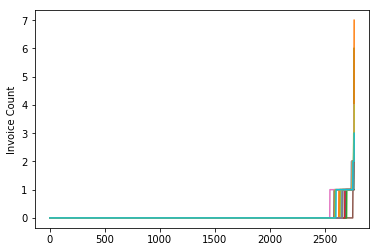

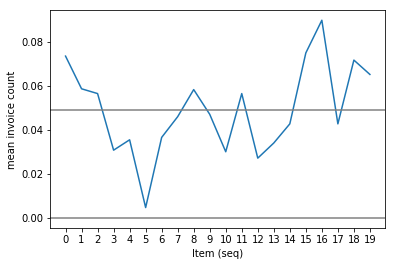

In [283]:
# check distibution of the target variables 

means = np.array([]).astype(int)
means
for x in range(0,nitm):
    plt.plot(np.sort(y_train.ix[:,x]))
    means = np.append(means, y_train.ix[:,x].mean())
plt.ylabel('Invoice Count')    
plt.show()    

plt.plot(np.array(range(0,nitm)).astype(str), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('Item (seq)')
plt.ylabel('mean invoice count')
plt.show()

- Target (예측대상 품목별 이용 결과) 변수의 형식을 구매여부, 구매금액, 구매빈도 등 다양한 방식으로 정의할 수 있음
- 추천서비스의 궁극적 목표에 따라 다른 설계 필요

In [37]:
# to binarize 
# 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_train.ix[:,x] = np.where(y_train.ix[:,x]>0,1,0) # Target
#     X_train.ix[:,x] = np.where(X_train.ix[:,x]>0,1,0) # inputs

In [284]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalized inputs (c.f. YouTube 2016)

from scipy.stats import percentileofscore

# X1_tmp = X_train.ix[:,1].copy()
# arr_sorted =  sorted(np.array(X_train.ix[:,1].copy()))
# s = X_train.ix[:,1]
# X1_tmp_qn = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs

# plt.scatter(X1_tmp, X1_tmp_qn)
# plt.xlabel('original')
# plt.ylabel('quantile normalized')
# plt.show()

for x in range(nitm):
    y_train.ix[:,x] = np.where(y_train.ix[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_train.ix[:,x].copy()))
    s = X_train.ix[:,x]
    X_train.ix[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs

- 구매여부 대신 구매건수를 타겟으로 설정하는 것도 대안
- c.f. YouTube는 시청시간이 메인타겟
- 여기서는 input feature를 건수 형식으로 정의 (단, 분포 변환 실시)

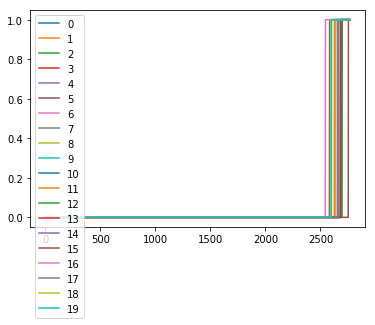

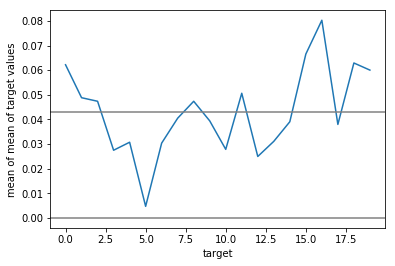

In [285]:
means = np.array([]).astype(int)
means
for x in range(nitm):
    plt.plot(np.sort(y_train.ix[:,x]))
    means = np.append(means, y_train.ix[:,x].mean())
plt.legend(list(range(nitm)), loc='upper left')
plt.show()    

plt.plot(range(0,nitm), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('target')
plt.ylabel('mean of mean of target values')
plt.show()

In [286]:
tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.ix[:,x], y_train.ix[:,x])[0,1])
print(tmparr) 
print('\nmean of corr = ' , tmparr.mean(), ' # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소')

y_train.head()

[ 0.37783154  0.33448917  0.29885265  0.16910448  0.34255717 -0.00524157
  0.40794923  0.31019882  0.33418791  0.3580654   0.35266814  0.25119211
  0.17755572  0.16402706  0.24071304  0.33754101  0.33180825  0.32356117
  0.40274567  0.33220913]

mean of corr =  0.2921008045625336  # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소


,sct20725,sct20727,sct20728,sct21212,sct21931,sct22086,sct22197,sct22382,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct23203,sct47566,sct84879,sct85099B,sct85123A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [287]:
y_train.columns[:nitm]

Index(['sct20725', 'sct20727', 'sct20728', 'sct21212', 'sct21931', 'sct22086',
       'sct22197', 'sct22382', 'sct22383', 'sct22386', 'sct22411', 'sct22423',
       'sct22457', 'sct22469', 'sct22720', 'sct23203', 'sct47566', 'sct84879',
       'sct85099B', 'sct85123A'],
      dtype='object')

In [288]:
# check distribution stats

print('mean : \n', X_train.mean(axis=0), '\n\nStdev : \n', X_train.std(axis=0))
print('\nmean : \n',y_train.mean(axis=0), '\n\nStdev : \n', y_train.std(axis=0),)

# Y 기간은 1개월이기 때문에 correlation 상대적으로 낮음 - fluctuaton
# Classification 형태로 구성하려고 하지만 class imbalance 상당히 존재 = rare event prediction 
# Y 기간이 더 짧아진다면(예: 1일) 그 만큼 imbalance 는 더 커질 것

print('\n평균 target event 비율 : ', y_train.mean(axis=0).mean())

mean : 
 sc20725     0.147177
sc20727     0.111789
sc20728     0.118304
sc21212     0.151106
sc21931     0.084740
sc22086     0.005755
sc22197     0.097943
sc22382     0.110932
sc22383     0.125593
sc22386     0.095518
sc22411     0.085950
sc22423     0.208643
sc22457     0.121145
sc22469     0.076846
sc22720     0.088061
sc23203     0.113534
sc47566     0.212475
sc84879     0.161202
sc85099B    0.153139
sc85123A    0.209834
dtype: float64 

Stdev : 
 sc20725     0.323689
sc20727     0.295242
sc20728     0.301150
sc21212     0.325699
sc21931     0.265634
sc22086     0.075468
sc22197     0.281186
sc22382     0.294358
sc22383     0.307623
sc22386     0.278411
sc22411     0.267123
sc22423     0.351223
sc22457     0.303462
sc22469     0.255311
sc22720     0.269552
sc23203     0.296792
sc47566     0.353155
sc84879     0.332088
sc85099B    0.327290
sc85123A    0.352416
dtype: float64

mean : 
 sct20725     0.062184
sct20727     0.048807
sct20728     0.047361
sct21212     0.027477
sct21931   

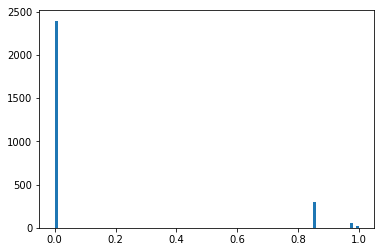

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc23203,sc47566,sc84879,sc85099B,sc85123A
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.810552,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.827396,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.755009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.865916,0.839291,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.731416,0.0,0.0,0.0


In [289]:
plt.hist(X_train.ix[:,2], bins=100)
plt.show()

X_train.head()


- YouTube(2016) 사용한 방식의 mimic으로 add super and sub linear derivatives of input features

In [290]:
# add super and sub linear derivatives of input features

# squared as super-linear
X_train_supl = X_train.apply(lambda x: x*x)
X_train_supl.columns = np.char.array(['sup']) + np.array(X_train_supl.columns)

# sqrt as sub-linear
X_train_subl = X_train.apply(lambda x: np.sqrt(x))
X_train_subl.columns = np.char.array(['sub']) + np.array(X_train_subl.columns)

X_train = pd.concat([X_train, X_train_supl, X_train_subl], axis=1)
X_train.shape

(2766, 60)

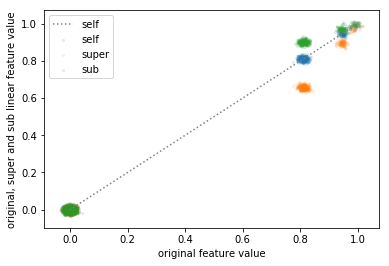

In [291]:
# compare distributions of orginal, super and sub features

plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.sc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.supsc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.subsc20725), alpha=0.1, s=5)
plt.plot(np.array(range(100))/100, np.array(range(100))/100, color='grey', linestyle=':')
plt.xlabel('original feature value')
plt.ylabel('original, super and sub linear feature value')
plt.legend(['self','self','super', 'sub'])
plt.show()

- original X 가 이미 0~1 scale 된 상태였기에 super, sub 모두 0~1 range에 속함

In [292]:
X_train.head()

,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,...,subsc22411,subsc22423,subsc22457,subsc22469,subsc22720,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.810552,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.827396,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.868912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.865916,0.839291,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.855228,0.0,0.0,0.0


- 하나의 Target 변수가 있는 경우와 Extreme multiclass classification 상황은 다름
- 각 Target별로 동일 문제 space의 서로 다른 영역에서 target event가 발생되므로 Class imbalance에 대처하기 위한 수단이 제한적일 수 밖에 없음

## 5.3. DNN Model Buidling

In [ ]:
# conda install tensorflow

In [ ]:
# pip install keras

In [293]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout

np.random.seed(23)

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(nitm*3, activation='relu', input_shape=(nitm*3,)))

num_layers = 3
nnode = 128

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='relu')) # activation = ['sigmoid', 'relu']
    model.add(Dropout(0.5))
    nnode = int(nnode/2)


# Add an output layer 
model.add(Dense(nitm,  activation='relu'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               7808      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [294]:
# fitting (training) DNN

import datetime
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    verbose=1, validation_split=0.2, shuffle=True)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2020-02-06 17:49:29.473751
Train on 2212 samples, validate on 554 samples
Epoch 1/100
2212/2212 [==============================] - 2s 753us/step - loss: 0.4861 - acc: 0.9559 - val_loss: 0.5835 - val_acc: 0.9539
Epoch 2/100
2212/2212 [==============================] - 1s 299us/step - loss: 0.4650 - acc: 0.9559 - val_loss: 0.5430 - val_acc: 0.9539
Epoch 3/100
2212/2212 [==============================] - 1s 289us/step - loss: 0.4326 - acc: 0.9554 - val_loss: 0.4599 - val_acc: 0.9539
Epoch 4/100
2212/2212 [==============================] - 1s 299us/step - loss: 0.4203 - acc: 0.9568 - val_loss: 0.3754 - val_acc: 0.9539
Epoch 5/100
2212/2212 [==============================] - 1s 290us/step - loss: 0.4042 - acc: 0.9572 - val_loss: 0.3129 - val_acc: 0.9539
Epoch 6/100
2212/2212 [==============================] - 1s 291us/step - loss: 0.3665 - acc: 0.9568 - val_loss: 0.3021 - val_acc: 0.9539
Epoch 7/100
2212/2212 [==============================] - 1s 301us/step - loss: 0.3470 - acc: 0.

Epoch 60/100
2212/2212 [==============================] - 1s 277us/step - loss: 0.1645 - acc: 0.9575 - val_loss: 0.1743 - val_acc: 0.9539
Epoch 61/100
2212/2212 [==============================] - 1s 275us/step - loss: 0.1618 - acc: 0.9578 - val_loss: 0.1723 - val_acc: 0.9542
Epoch 62/100
2212/2212 [==============================] - 1s 272us/step - loss: 0.1684 - acc: 0.9573 - val_loss: 0.1758 - val_acc: 0.9540
Epoch 63/100
2212/2212 [==============================] - 1s 287us/step - loss: 0.1679 - acc: 0.9575 - val_loss: 0.1748 - val_acc: 0.9542
Epoch 64/100
2212/2212 [==============================] - 1s 277us/step - loss: 0.1682 - acc: 0.9577 - val_loss: 0.1723 - val_acc: 0.9542
Epoch 65/100
2212/2212 [==============================] - 1s 275us/step - loss: 0.1633 - acc: 0.9579 - val_loss: 0.1713 - val_acc: 0.9545
Epoch 66/100
2212/2212 [==============================] - 1s 278us/step - loss: 0.1671 - acc: 0.9570 - val_loss: 0.1685 - val_acc: 0.9541
Epoch 67/100
2212/2212 [==========

## 5.4. Modeling Result Assessment

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


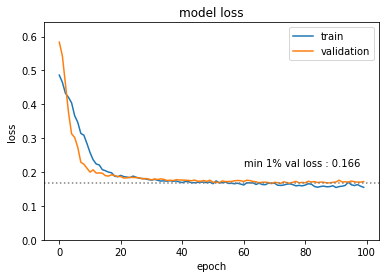

(2766, 20)


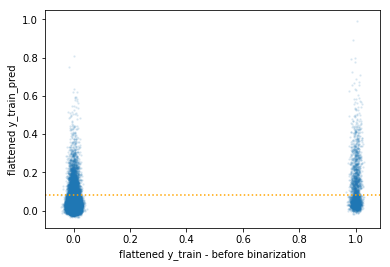

mae =  0.07263952082165114
corr =  0.3401656487305787
r_sqrd =  0.10585


[0.11424439 0.09869848 0.09399855 0.03940709 0.06941432 0.
 0.09110629 0.08532176 0.09255242 0.08098337 0.06905279 0.07013738
 0.07086045 0.02169197 0.07411424 0.159436   0.11641359 0.0285611
 0.09291396 0.09363702]
10
33
56


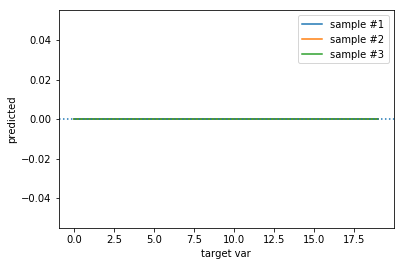

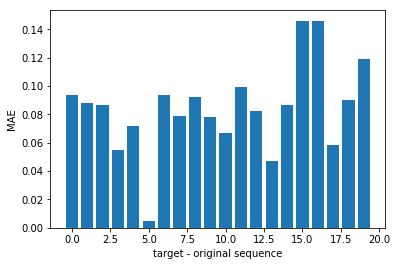

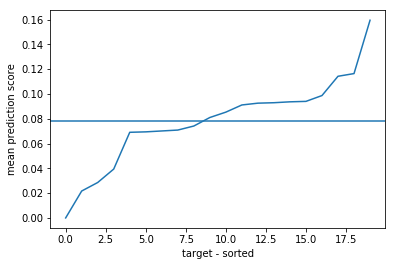

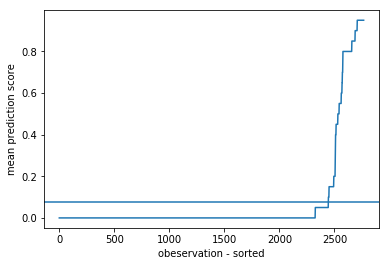

range of prediction :  0.0 1.0


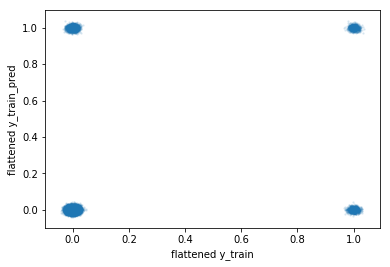


Accuracy: 91.58

Confusion Matrix : 
 [[49640  3301]
 [ 1358  1021]]

Precision % :  42.917192097519965
Recall % :  23.623322535863025


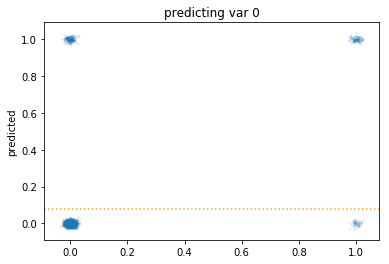

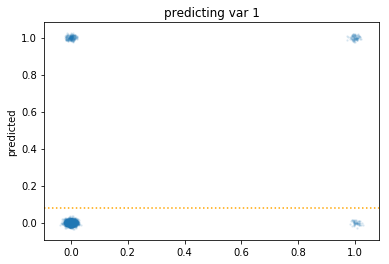

In [295]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
min1pcntloss = np.percentile(history.history['val_loss'],1)
plt.axhline(min1pcntloss, color='grey', linestyle=':')
losstext = 'min 1% val loss : ' + str(round(min1pcntloss,3))
plt.text(60, min1pcntloss+0.05, losstext)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


#--------------

y_train_pred = model.predict(X_train)
print(y_train_pred.shape)

cutoff = 0.08

y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
y_train_pred_f = np.where(y_train_pred_f>1, 1, y_train_pred_f)

plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train - before binarization')
plt.ylabel('flattened y_train_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

print('mae = ', abs(y_train_f - y_train_pred_f).mean())
print('corr = ' , np.corrcoef(y_train_f, y_train_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_train_f, y_train_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_train_pred[:, x] = np.where(y_train_pred[:, x]<cutoff,0, 1)

print(y_train_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (23*x) + 10 
    print(x1)
    plt.plot(y_train_pred[x1,:])
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_train_pred[:, x] - y_train.ix[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_train_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_train_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train')
plt.ylabel('flattened y_train_pred')
plt.show()


y_train_predc = np.where(y_train_pred >cutoff, 1, 0)
y_trainc = np.where(y_train >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_train_f, y_train_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_train_f), list(y_train_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nPrecision % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)
print('Recall % : ', (cnf_matrix[1,1])/(cnf_matrix[:,1].sum())*100)


plt.scatter(rjitt(y_train.ix[:,0]), rjitt(y_train_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_train.ix[:,1]), rjitt(y_train_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()


### Check testset (m+1) performance
- 8월 중의 카테고리별 고객 이용패턴을 예측 결과와 비교 

In [296]:
# Months for test X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-05', '2011-06', '2011-07'])]
# Months for test Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-08'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15.head()

X_test = tr15.ix[:,1:(nitm+1)]
y_test = tr15.ix[:,(nitm+1):((2*nitm)+1)]



(4213, 3)
(598, 21)


In [51]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_test.ix[:,x] = np.where(y_test.ix[:,x]>0,1,0)
#     X_test.ix[:,x] = np.where(X_test.ix[:,x]>0,1,0)

In [297]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalize inputs (c.f. YouTube 2016)

from scipy.stats import percentileofscore

for x in range(nitm):
    y_test.ix[:,x] = np.where(y_test.ix[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_test.ix[:,x].copy()))
    s = X_test.ix[:,x]
    X_test.ix[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs
    

In [298]:
# add super and sub linear derivatives of input features

X_test_supl = X_test.apply(lambda x: x*x)
X_test_supl.columns = np.char.array(['sup']) + np.array(X_test_supl.columns)

X_test_subl = X_test.apply(lambda x: np.sqrt(x))
X_test_subl.columns = np.char.array(['sub']) + np.array(X_test_subl.columns)

X_test = pd.concat([X_test, X_test_supl, X_test_subl], axis=1)
X_test.shape

(1384, 60)

(1384, 20)
(1384, 20) (27680,) (27680,)


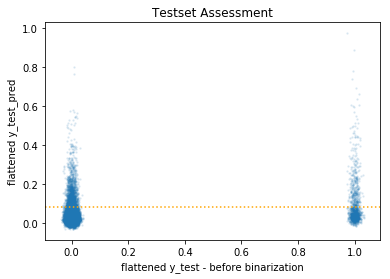

mae =  0.07715512679494793
corr =  0.23500939225472856
r_sqrd =  0.05407


[0.11777457 0.09971099 0.091763   0.0382948  0.06647399 0.
 0.08959538 0.08381503 0.08959538 0.07731214 0.06647399 0.06647399
 0.06791908 0.01878613 0.07080925 0.1734104  0.12138728 0.02456647
 0.09104046 0.09104046]
10
30
50


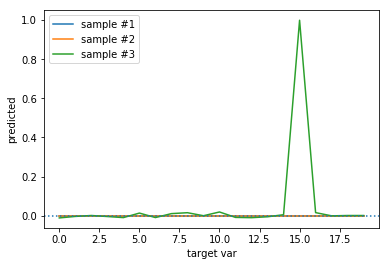

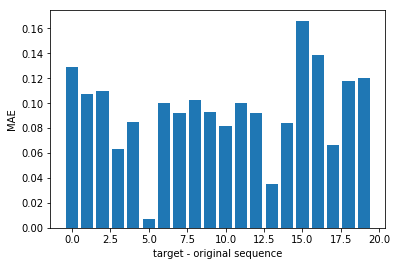

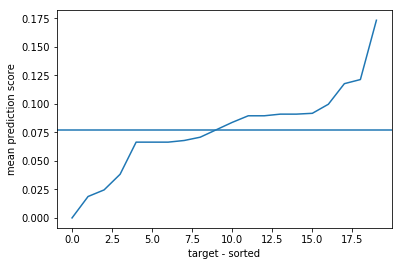

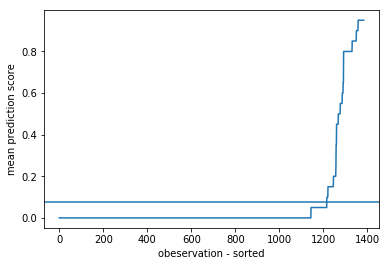

range of prediction :  0.0 1.0


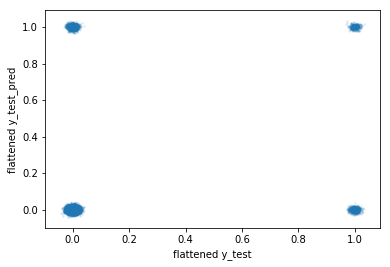


Accuracy: 90.53

Confusion Matrix : 
 [[24660  1740]
 [  880   400]]

Precision % :  31.25
Recall % :  18.69158878504673


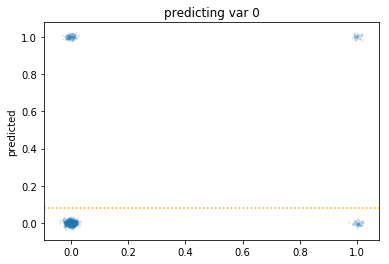

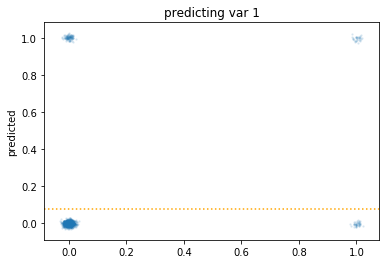

In [299]:
y_test_pred = model.predict(X_test)
print(y_test_pred.shape)

cutoff = 0.08

y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
y_test_pred_f = np.where(y_test_pred_f>1, 1, y_test_pred_f)

print(y_test.shape, y_test_f.shape, y_test_pred_f.shape)

plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test - before binarization')
plt.ylabel('flattened y_test_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.title('Testset Assessment')
plt.show()

print('mae = ', abs(y_test_f - y_test_pred_f).mean())
print('corr = ' , np.corrcoef(y_test_f, y_test_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_test_f, y_test_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_test_pred[:, x] = np.where(y_test_pred[:, x]<cutoff,0, 1)

print(y_test_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (20*x) + 10 
    print(x1)
    plt.plot(rjitt(y_test_pred[x1,:]))
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_test_pred[:, x] - y_test.ix[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_test_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_test_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test')
plt.ylabel('flattened y_test_pred')
plt.show()


y_test_predc = np.where(y_test_pred >cutoff, 1, 0)
y_testc = np.where(y_test >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_test_f, y_test_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_test_f), list(y_test_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nPrecision % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)
print('Recall % : ', (cnf_matrix[1,1])/(cnf_matrix[:,1].sum())*100)


plt.scatter(rjitt(y_test.ix[:,0]), rjitt(y_test_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_test.ix[:,1]), rjitt(y_test_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

- (batchsize 16, epoch 200) is more accurate than (batchsize 32, epoch 150)
- quantile normalization adds value. Still there seems to be a room to calibrate further
- adding super and sub linear derivative input features seems to work a litte

[Discussion]
- Why not 100% accurate?
- Seasonal difference in item popularity?
- Inpust and targets should be from the same item pool?

## 5.5. Making Recommendations (=Inference)

In [300]:
# randomly select 100 customers from testset 

nsmpls = 300
trtestrun = tr15.sample(n=nsmpls, replace=False)

testrun_smp_idx = trtestrun.index
print(X_test.ix[testrun_smp_idx].shape)
X_test.ix[testrun_smp_idx].head()


(300, 60)


,sc20725,sc20727,sc20728,sc21212,sc21931,sc22086,sc22197,sc22382,sc22383,sc22386,...,subsc22411,subsc22423,subsc22457,subsc22469,subsc22720,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A
461,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.926998,0.0,0.882828,0.0,0.000000,0.0,0.00000
314,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.86636
860,0.0,0.0,0.0,0.0,0.0,0.0,0.878272,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000
122,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.882843,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.86636
1203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.903884,0.0,0.00000


In [301]:
w, h = nitm, nsmpls

testrecomm_mat = np.array([[None for x in range(w)] for y in range(h)])

testrunX = X_test.ix[testrun_smp_idx]
testrunY = y_test.ix[testrun_smp_idx]

for j in range(len(testrun_smp_idx)):
    X_testrun = testrunX.ix[testrun_smp_idx[j],:]
    # print(X_testrun, X_testrun.shape)
    
    y_test_pred = model.predict(np.array(X_testrun).reshape((-1,60)))
    # print(y_test_pred)

        
    # [ alternatively ] above median probability can be used as the threshold
    # y_test_pred[0] = np.where(y_test_pred[0]>=np.median(y_test_pred[0]), 1, 0)
    # y_test_pred[0] = np.where(y_test_pred[0]>=0.02, 1, 0)
    
    # not to recommend items already purchased during X period
    recomm = y_test_pred[0] - testrunY.ix[testrun_smp_idx[j],:]
    recomm = np.where(recomm <0, 0, recomm)
    
    # 20개 아이템 중 스코어 순 상위 3개만 선정해서 순서대로 추천
    recomm = np.array(recomm).flatten()   
    recomm = [round(d,4) if d >= np.percentile(recomm,85) and d>0 else 0 for d in recomm]
    print('recomm for test cust ', j ,' : ' , recomm )
    testrecomm_mat[j,:] = recomm
    

recomm for test cust  0  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  1  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  2  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  3  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  4  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  5  :  [0, 0, 0, 0, 0, 0, 0.0473, 0, 0, 0, 0, 0, 0, 0, 0, 0.073, 0.0569, 0, 0, 0]
recomm for test cust  6  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.042, 0, 0, 0, 0, 0.0558, 0, 0, 0.0409]
recomm for test cust  7  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  8  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  9  :  [0.081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

recomm for test cust  79  :  [0, 0, 0, 0, 0, 0, 0.0816, 0, 0, 0, 0, 0.0681, 0, 0, 0.068, 0, 0, 0, 0, 0]
recomm for test cust  80  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  81  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  82  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  83  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  84  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  85  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  86  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  87  :  [0.0662, 0, 0, 0, 0, 0, 0.0613, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0751, 0, 0, 0]
recomm for test cust  88  :  [0.1062, 0, 0, 0, 0, 0, 0, 

recomm for test cust  157  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  158  :  [0.1583, 0.1173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1477, 0, 0, 0, 0]
recomm for test cust  159  :  [0.1137, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1232, 0.096, 0, 0, 0]
recomm for test cust  160  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  161  :  [0, 0, 0, 0, 0, 0, 0.0468, 0, 0, 0, 0, 0, 0, 0, 0, 0.0724, 0.0562, 0, 0, 0]
recomm for test cust  162  :  [0, 0, 0, 0, 0, 0, 0.1164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1493, 0, 0, 0.1262]
recomm for test cust  163  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  164  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  165  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  166  :  [0, 0, 0, 0, 0, 0

recomm for test cust  242  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  243  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  244  :  [0, 0.1229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1521, 0.12, 0, 0, 0]
recomm for test cust  245  :  [0.2958, 0.2191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2255, 0, 0, 0, 0]
recomm for test cust  246  :  [0, 0, 0, 0, 0, 0, 0.0502, 0, 0, 0, 0, 0.0436, 0, 0, 0, 0.0767, 0, 0, 0, 0]
recomm for test cust  247  :  [0, 0, 0, 0, 0, 0, 0.0477, 0, 0, 0, 0, 0, 0, 0, 0, 0.0575, 0.057, 0, 0, 0]
recomm for test cust  248  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0.042, 0, 0, 0, 0, 0.0558, 0, 0, 0]
recomm for test cust  249  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  250  :  [0, 0, 0, 0, 0, 0, 0.0466, 0, 0, 0, 0, 0, 0, 0, 0, 0.0719, 0.0558, 0, 0, 0]
recomm for test cust  251  :  [0, 0, 0, 0, 0, 0, 0

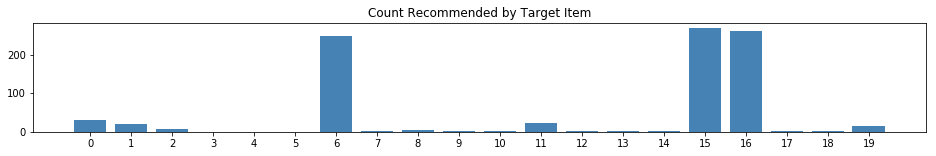

Total Count Recommended :  896.0 ( 99.56 %)


In [302]:
means = np.array([])
for x in range(nitm):
    tmp_cnt = np.array([1 if y >0 else y for y in testrecomm_mat[:,x]])
    means = np.append(means, tmp_cnt.sum())

plt.figure(figsize=(16,2))
var_labels = np.array(range(nitm)).astype(str)
plt.bar(var_labels, means, color='steelblue')
plt.title('Count Recommended by Target Item')
plt.show()

# 3건 모두 추천이 이루어진 건의 수와 비율 확인
print('Total Count Recommended : ', means.sum(), '(', round(means.sum()/(h*3)*100,2), '%)')

- 기준을 만족하는 제안건이 3건이 되지 않는 경우도 발생 가능
- 무조건 3건을 채우기로 한 경우라면 이를 위한 추가적인 장치 (e.g. random, simple logic) 마련 필요 
- 보다 popular한 item 혹은 특정 item으로 추천이 집중되는 쏠림 현상 보임 (참고: 일부는 이미 구매한 상품을 제외한 영향)
- Score 자체를 그대로 사용하는 대신 추천 분산을 유도하는 로직 적용 가능

- recsys 2019 paper on YouTube explained :  https://towardsdatascience.com/how-youtube-recommends-videos-b6e003a5ab2f 